In [33]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
filename = 'NSEI'
df = pd.read_csv(filename + '.csv')

In [35]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date'])

In [36]:
df = df[(df['Date'].dt.dayofweek !=5) &(df['Date'].dt.dayofweek) !=6]
df = df.dropna(axis=0, how='all', subset=df.columns[1:])
df = df.sort_values(['Date'])

In [38]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

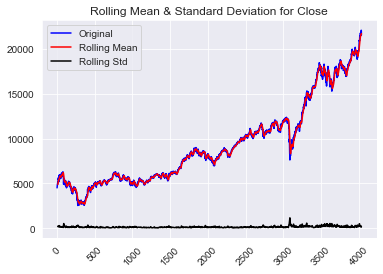

Results of Dickey-Fuller Test:
Test Statistic                    1.172664
p-value                           0.995791
# Lags Used                      12.000000
Number of Observations Used    3991.000000
Critical Value (1%)              -3.431990
Critical Value (5%)              -2.862264
Critical Value (10%)             -2.567156
dtype: float64


In [39]:
test_stationarity(df, "Close")

In [40]:
df['Day_Return'] = ((df['Close'] - df['Close'].shift(1))/df['Close'].shift(1))*100
df['50_Day_Return'] = ((df['Close'] - df['Close'].shift(50))/df['Close'].shift(50))*100
df2 = df.dropna(subset=['50_Day_Return'])
df2.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Day_Return,50_Day_Return
50,2007-11-28,5699.549805,5749.950195,5595.500000,5617.549805,5617.549805,0.0,-1.414496,24.983034
51,2007-11-29,5617.799805,5725.000000,5612.100098,5634.600098,5634.600098,0.0,0.303518,23.940871
52,2007-11-30,5633.899902,5782.549805,5632.649902,5762.750000,5762.750000,0.0,2.274339,21.773535
53,2007-12-03,5765.450195,5878.799805,5754.600098,5865.000000,5865.000000,0.0,1.774326,23.537409
54,2007-12-04,5870.200195,5897.250000,5840.299805,5858.350098,5858.350098,0.0,-0.113383,21.101598
55,2007-12-05,5861.899902,5949.299805,5859.950195,5940.000000,5940.000000,0.0,1.393735,20.433068
56,2007-12-06,5941.049805,6027.049805,5919.799805,5954.700195,5954.700195,0.0,0.247478,20.568555
57,2007-12-07,5963.600098,6042.100098,5894.799805,5974.299805,5974.299805,0.0,0.329145,20.925004
58,2007-12-10,5974.000000,6015.299805,5923.350098,5960.600098,5960.600098,0.0,-0.229311,19.198895
59,2007-12-11,5960.399902,6111.200195,5960.399902,6097.250000,6097.250000,0.0,2.292553,21.426506


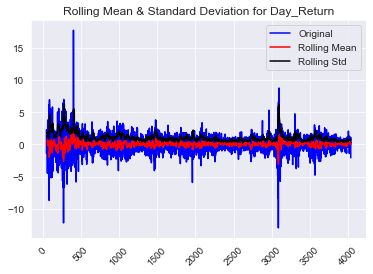

Results of Dickey-Fuller Test:
Test Statistic                -1.376444e+01
p-value                        9.945425e-26
# Lags Used                    1.600000e+01
Number of Observations Used    3.937000e+03
Critical Value (1%)           -3.432012e+00
Critical Value (5%)           -2.862274e+00
Critical Value (10%)          -2.567161e+00
dtype: float64


In [41]:
test_stationarity(df2, "Day_Return")

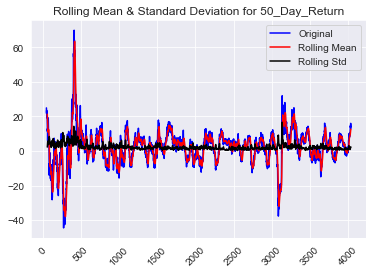

Results of Dickey-Fuller Test:
Test Statistic                -7.088072e+00
p-value                        4.484178e-10
# Lags Used                    2.200000e+01
Number of Observations Used    3.931000e+03
Critical Value (1%)           -3.432015e+00
Critical Value (5%)           -2.862276e+00
Critical Value (10%)          -2.567162e+00
dtype: float64


In [42]:
test_stationarity(df2, "50_Day_Return")

In [43]:
final_cols =  ["Open", "High", "Low", "Close", "Day_Return", "50_Day_Return"]
df3 = df2[final_cols]

test_per= 0.1
test_ob = int(np.round(test_per * len(df3)))

traing_data = df3[: -test_ob]
testing_data = df3[-test_ob:]


vald_per = 0.7
val_obs = int(np.round(vald_per* len(testing_data)))

validation_data = testing_data[: -val_obs]
outsample_data = testing_data[-val_obs: ]

In [44]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length

In [45]:
price = df3[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


C:\Users\dipgh\AppData\Local\Temp\ipykernel_20836\2385142508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [46]:
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [47]:
x_test_val = x_test[:10]
y_test_val = y_test[:10]

x_test = x_test[:-10]
y_test = y_test[:-10]

In [48]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [49]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [64]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

In [66]:
model = CNN_LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,  num_classes=output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [67]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.5819388031959534
Epoch  1 MSE:  0.211831733584404
Epoch  2 MSE:  0.06735395640134811
Epoch  3 MSE:  0.12365474551916122
Epoch  4 MSE:  0.06797675788402557
Epoch  5 MSE:  0.06801895052194595
Epoch  6 MSE:  0.08336646109819412
Epoch  7 MSE:  0.08198931813240051
Epoch  8 MSE:  0.06948625296354294
Epoch  9 MSE:  0.058125048875808716
Epoch  10 MSE:  0.055499106645584106
Epoch  11 MSE:  0.05986202880740166
Epoch  12 MSE:  0.06239069253206253
Epoch  13 MSE:  0.057403866201639175
Epoch  14 MSE:  0.048027463257312775
Epoch  15 MSE:  0.04224967584013939
Epoch  16 MSE:  0.04306047782301903
Epoch  17 MSE:  0.03776742145419121
Epoch  18 MSE:  0.028029397130012512
Epoch  19 MSE:  0.02021905779838562
Epoch  20 MSE:  0.015218205749988556
Epoch  21 MSE:  0.011308186687529087
Epoch  22 MSE:  0.007100180722773075
Epoch  23 MSE:  0.0038400357589125633
Epoch  24 MSE:  0.005785753484815359
Epoch  25 MSE:  0.008127558045089245
Epoch  26 MSE:  0.007268375251442194
Epoch  27 MSE:  0.0085587985

In [68]:
# x_test_val = torch.from_numpy(x_test_val).type(torch.Tensor)
# y1_train_pred = model(x_test_val)

In [71]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

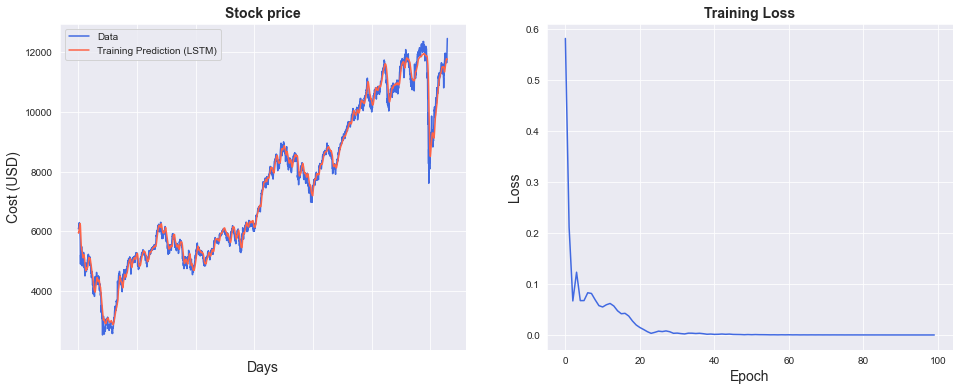

In [72]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)


In [32]:
len(x_test[:-4])

783